# [Cointegration tests on time series](https://medium.com/bluekiri/cointegration-tests-on-time-series-88702ea9c492)



In a previous [post](https://josephchenhk.github.io/stationary_time_series_test/), we examined the fundamental tools to test for stationarity on time series using Python. If we use the tools described in the article, we will very soon realise that most time series are neither stationary nor mean reverting. In this new article we are going to examine how we can test two (or more) non-stationary time series to check whether the combined value is stationary.

This is where we should introduce the notion of $\color{blue}{\textbf{cointegration}}$ .

`If we are able to find a stationary linear combination of several time series that are not themselves stationary, then these are called cointegrated.`

We are going to see two different tests: the simpler **Cointegrated Augmented Dickey-Fuller test (CADF)** will be useful for pairs only, but we can apply the **Johansen test** to any number of time series.

# Cointegrated Augmented Dickey-Fuller Test

In the previous post, we saw how the ADF and Variance Ratio can test a given time series for mean reversion and stationarity, but we don’t know the number of units o percentage we should use to combine them into the stationary basket of elements we are looking for.

`We have to be aware that just because a set of time series is cointegrating doesn’t mean that any random linear combination of the series will form a stationary basket of elements.`

To easily create the test we can use the procedure by Engle and Granger, which can be defined as the following steps:

1. Determine the optimal hedge ratio by running a lineal regression fit between the two series.
2. Use the hedge computed in step 1 to form a portfolio.
3. Run a stationarity test on the portfolio created in step 2.

Taking advantage of the code already written in the previous article, we can write the test easily with the help of the numpy and statsmodels libraries in the following way:

# Brownian Motion

**Random Walk** is a stochastic process in a *discrete* space; and **Brownian Motion**, is a stochastic process in a *continuous* space. Suppose our space is integer space, we can use the following code to generate a Brownian motion:

In [6]:
import numpy as np

def Brownian_motion_generator(initial_condition:int, step:int, boundary:int):  
    assert step>0, "step should be positive"
    assert boundary>0, "boundary should be positive"
    assert isinstance(initial_condition, int), "initial_condition should be an integer"
    random_int_list = [initial_condition]
    for _ in range(step-1):
        random_int_list.append(random_int_list[-1] + np.random.randint((-1)*boundary, boundary+1))
    return random_int_list

we can have a direct impression of Brownian motion by ploting the 2D scatters:

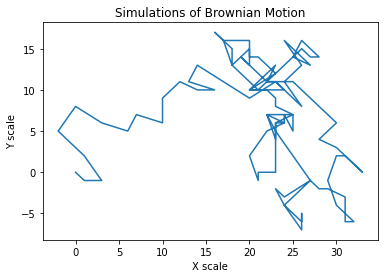

In [24]:
import matplotlib.pyplot as plt

np.random.seed(2021)
X = Brownian_motion_generator(0, 100, 3)
Y = Brownian_motion_generator(0, 100, 3)
plt.plot(X,Y)
plt.title('Simulations of Brownian Motion')
plt.xlabel('X scale')
plt.ylabel('Y scale')
plt.show()

# Arithmetic Brownian and Geometric Brownian

The <span style="color:blue">**arithmetic Brownian motion**</span> (with drift) is the solution of

$$
dX_t = \alpha dt + \sigma dW_t
$$

with initial condition $X_0 = x_0$. It can be obtained from direct integration of the stochastic differential equation

$$
X_t =x_0 +\alpha t+\sigma W_t
$$

The <span style="color:blue">**geometric Brownian motion**</span> (GBM) can be derived from the arithmetic Brownian motion by defining $Y_t = e^{X_t}$ and using $\text{It}\hat{\text{o}}$’s lemma

$$
dY_t = \left(\alpha Y_t + \frac{\sigma^2}{2} Y_t \right)dt + \sigma Y_t dW_t
$$

With $\mu = \alpha + \sigma^2/2 the geometric Brownian motion is defined by

$$
dY_t = \mu Y_t dt + \sigma Y_t dW_t
$$

with initial condition $Y_0 = y_0$. The solution can then be found by using the solution of the arithmetic Brownian motion

$$
Y_t =y_0 e^{\left(\mu - \frac{\sigma^2}{2}\right) t+\sigma W_t}
$$

One of the main feature of the geometric Brownian motion is proportionality of the drift term to $Y_t$ itself.

# Markov Process

A **Markov process** is a random process in which the future is independent of the past, given the present. Thus, Markov processes are the natural stochastic analogs of the deterministic processes described by differential and difference equations. 

Markov process is a special form of Brownian motion (random processes). It states that the future observation only depends on the current observation, but has nothing to do with the historical observations, i.e., in mathematical form:

$$
dX_t = X_t - X_{t-1} = f(X_{t-1}) \space\space [\textbf{has nothing to do with} X_{t-2}, X_{t-3}, ...]
$$

It is therefore a Markov process can also be called <span style="color:red">**memoryless**</span>.

# Wiener Process

**Wiener process** is a real valued continuous-time stochastic process named in honor of American mathematician Norbert Wiener for his investigations on the mathematical properties of the one-dimensional Brownian motion. It is often also called Brownian motion due to its historical connection with the physical process of the same name originally observed by Scottish botanist Robert Brown.

But strictly speaking, 

* Brownian motion = random process (in continuous space)

* Brownian motion + history independent = Markov Process

* Markov process + $\Delta X_t$ ~ $N(0, \Delta t)$ = Wiener Process

$$
\Delta z = \epsilon \sqrt{\Delta t}, \text{ with } \epsilon \sim N(0, 1)
$$

* Wiener process + drift term = (Generalized) Wiener Process

$$
\Delta z = \mu \Delta t + \sigma\epsilon \sqrt{\Delta t}, \text{ with } \epsilon \sim N(0, 1)
$$

There are two properties a Wiener process must meet:
    
1. <span style="color:blue">**normal distribution of increments**</span>: for all $\Delta t$, the increment $\Delta z$ follows a normal distribution with mean=0, and std=$\Delta t$

2. <span style="color:blue">**independence of increments**</span>: for ${\forall} \Delta t_1 \neq \Delta t_2$, $\Delta z_1$ is independent of $\Delta z_2$ 

From the definition above, we have a conclusion that

<span style="color:green">**The variance of a Wiener process is proportional to the time interval**</span>

$$
\textbf{Var}(\Delta z) \propto \Delta t
$$

### Proof:

$$
\begin{align}
\textbf{Var}(\Delta z) 
&= \textbf{Var}(\mu \Delta t + \sigma\epsilon \sqrt{\Delta t}) \\
&= \textbf{Var}(\mu \Delta t) + \textbf{Var}(\sigma\epsilon \sqrt{\Delta t}) \\
&= 0 + \sigma^2 \cdot \Delta t \cdot \textbf{Var}(\epsilon) \\
&= 0 + \sigma^2 \cdot \Delta t \cdot 1 \\
&= \sigma^2 \cdot \Delta t \propto \Delta t
\end{align}
$$

In [15]:
import numpy as np

def Wiener_process_generator(initial_condition:int, step:int, drift_rate:float, delta_t:float, sigma:float):    
    random_int_list = [initial_condition]
    for _ in range(0,step-1):
        random_int_list.append(random_int_list[-1] + drift_rate*delta_t + sigma*np.sqrt(delta_t)*np.random.normal(0, 1))
    return random_int_list

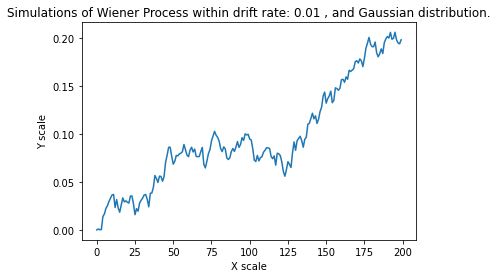

In [27]:
step = 200
initial_condition = 0
drift_rate = 0.01
delta_t = 0.1
sigma = 0.02
np.random.seed(2022)

X = [i for i in range(step)]
Y = Wiener_process_generator(initial_condition, step, drift_rate, delta_t, sigma)

plt.plot(X,Y)

plt.title('Simulations of Wiener Process within drift rate: %.2f , and Gaussian distribution.' % (drift_rate))
plt.xlabel('X scale')
plt.ylabel('Y scale')
plt.show()

# Ornstein Uhlenbeck Process

Ornstein-Uhlenbeck (OU) process describe a mean-reverting process. It simply replace the drift term in arithmetic Brownian motion with an mean-reverting term depending on the variable itself:


$$
dU_t = \kappa(\theta - U_t) dt + \sigma dW_t
$$

The sign of $\kappa$ determines if the equilibrium is attractive or repulsive. For an OU process is used to model mean reverting behaviour we have $\kappa>0$. If $\kappa<0$, the equation models a trending behaviour. If $\kappa=0$, it is a random process.

We can implement an OU process generator as below:

In [4]:
import numpy as np

def ou_process_generator(initial_condition:int, step:int, kappa:float, theta:float, delta_t:float, sigma:float):    
    random_int_list = [initial_condition]
    for _ in range(0,step-1):
        random_int_list.append(random_int_list[-1] + kappa*(theta-random_int_list[-1])*delta_t + sigma*np.sqrt(delta_t)*np.random.normal(0, 1))
    return random_int_list

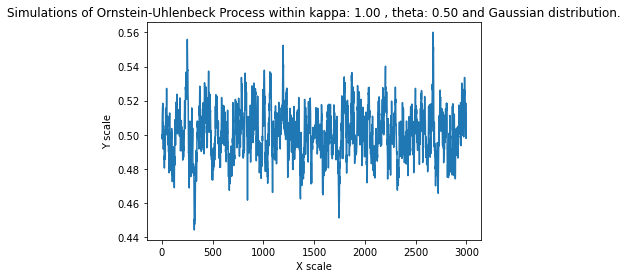

In [136]:
step = 3000
initial_condition = 0.5
kappa = 1 # positive kappa gives us mean-reverting series
theta = 0.5
delta_t = 0.1
sigma = 0.02
np.random.seed(2022)

X = [i for i in range(step)]
Y = ou_process_generator(initial_condition, step, kappa, theta, delta_t, sigma)

plt.plot(X,Y)

plt.title('Simulations of Ornstein-Uhlenbeck Process within kappa: %.2f , theta: %.2f and Gaussian distribution.' % (kappa, theta))
plt.xlabel('X scale')
plt.ylabel('Y scale')
plt.show()

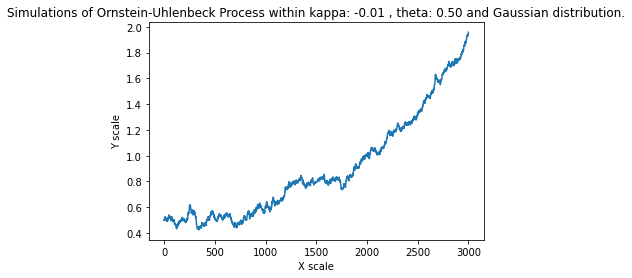

In [99]:
step = 3000
initial_condition = 0.5
kappa = -0.01 # negative kappa gives us trending series
theta = 0.5
delta_t = 0.1
sigma = 0.02
np.random.seed(2022)

X = [i for i in range(step)]
Y = ou_process_generator(initial_condition, step, kappa, theta, delta_t, sigma)

plt.plot(X,Y)

plt.title('Simulations of Ornstein-Uhlenbeck Process within kappa: %.2f , theta: %.2f and Gaussian distribution.' % (kappa, theta))
plt.xlabel('X scale')
plt.ylabel('Y scale')
plt.show()

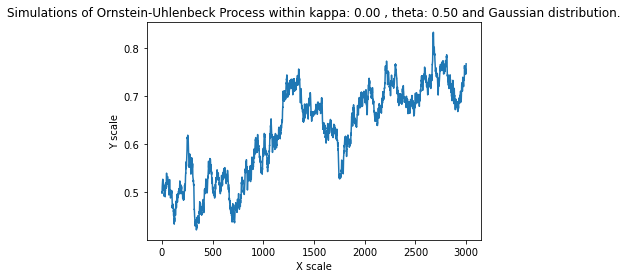

In [102]:
step = 3000
initial_condition = 0.5
kappa = 0 # kappa=0 gives us random walk series
theta = 0.5
delta_t = 0.1
sigma = 0.02
np.random.seed(2022)

X = [i for i in range(step)]
Y = ou_process_generator(initial_condition, step, kappa, theta, delta_t, sigma)

plt.plot(X,Y)

plt.title('Simulations of Ornstein-Uhlenbeck Process within kappa: %.2f , theta: %.2f and Gaussian distribution.' % (kappa, theta))
plt.xlabel('X scale')
plt.ylabel('Y scale')
plt.show()

# Hurst Exponent

We can use <span style="color:blue">**Hurst exponent**</span> to detect whether a time series is random process, or mean-reverting, or trending.

The idea behind the Hurst Exponent calculation is that we can use the variance of a time series to assess the rate of diffusive behaviour. For an arbitrary time lag , the variance is given by:

$$
\textbf{Var}(\tau) = \textbf{Var}(y(t+\tau) - y(t)) = <|y(t+\tau) - y(t)|^2>
$$

where $\tau$ is an arbitrary time lag, and $<...>$ is an average over all $t$'s. For $\{y_t\}$ that follows Arithmetic Brownian motion (therefore $z_t = \textbf{e}^{y_t}$ follows a Geometric Brownian motion process, <span style="color:blue">usually we use $\{z_t\}$ to model the stock prices, and $y_t = \textbf{log}(z_t)$ satisfies a Arithmetic Brownian motion process</span>), as we have demonstrated that the variance is proportional to the time lag:

$$
<|y(t+\tau) - y(t)|^2> \sim \tau
$$

This relationship turns into an equality with some proportionally constant for a large value of $\tau$, but it may deviate for a small $\tau$. So if the time series is mean reverting this won’t hold.

Now we can introduce the Hurst exponent H:

$$
<|y(t+\tau) - y(t)|^2> \sim \tau^{2H}
$$

For a time series with a geometric random walk behaviour, $H=0.5$, for a mean reverting series, $H<0.5$, and, finally, for a trending series $H>0.5$. $H$ also is an indicator for the degree of mean reversion or trendiness: as $H$ decreases towards 0, the series is more mean reverting and as it increases towards 1, it is more trending.

There are <span style="color:blue">**various methods**</span> of implementing a Hurst Exponent, depending on the definition (calculation) of variance. We introduce two commonly used methods here. One is defining the variance as square of standard deviations; another one is defining variance as square of **rescaled range**.

## Hurst Exponent (1)

In [271]:
def hurst_exponent_1(ts):
    """Returns the Hurst Exponent of the time series vector ts
    Ref: 
    1. https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing/
    2. https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e
    """
    N = len(ts)
    min_lag = 2
    max_lag = 100
    lags = range(min_lag, max_lag+1)

    # Calculate the array of the variances of the lagged differences
    tau = [np.square(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent (2*H)
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]/2.0

## Hurst Exponent (2)

In [269]:
def hurst_exponent_2(ts):
    """Returns the Hurst Exponent of the time series vector ts
    Ref:
    1. https://en.wikipedia.org/wiki/Hurst_exponent
    """
    # Convert into np.array if the original ts is not a np.array
    ts = np.array(ts)
    
    N = len(ts)
    min_lag = 10
    max_lag = int(np.floor(N/2))
    lags = range(min_lag, max_lag+1)

    # Calculate different rescaled ranges
    ARS = []
    for lag in lags:
        # divide ts into different samples
        num = int(np.floor(N/lag))
        RS = []
        for n in range(num):
            X = ts[n*lag:(n+1)*lag] 
            # [Important]: take lagged differences
            X_diff = X[1:] - X[:-1] # X_diff = np.diff(X)
            Y = X_diff - X_diff.mean()
            Z = np.cumsum(Y)
            R = Z.max() - Z.min()
            S = Y.std(ddof=1)
            RS.append(R/S)
        
        ARS.append(sum(RS)/len(RS))   
    
    # Note we are estimating rescaled range (RS), instead of
    # RS^2, so the factor 2 disappear here.
    poly = np.polyfit(np.log(lags), np.log(ARS), 1)
    return poly[0]

There is a library called `hurst` implemented in Python in Github. We may use it as a benchmark to compare with our implementations:

In [274]:
step = 10000
initial_condition = 0.5
theta = 0.5
delta_t = 0.1
sigma = 0.02
np.random.seed(2022)

kappa = 1 # positive kappa gives us mean-reverting series
Y = ou_process_generator(initial_condition, step, kappa, theta, delta_t, sigma)
print("Method 1: [Mean-reverting] Hurst=%.4f"%hurst_exponent_1(Y))
print("Method 2: [Mean-reverting] Hurst=%.4f"%hurst_exponent_2(Y))
print("Benchmark: [Mean-reverting] Hurst=%.4f"%compute_Hc(Y, simplified=False)[0])
print()

kappa = -0.01 # negative kappa gives us trending series
Y = ou_process_generator(initial_condition, step, kappa, theta, delta_t, sigma)
print("Method 1: [Trending] Hurst=%.4f"%hurst_exponent_1(Y))
print("Method 2: [Trending] Hurst=%.4f"%hurst_exponent_2(Y))
print("Benchmark: [Trending] Hurst=%.4f"%compute_Hc(Y, simplified=False)[0])
print()

kappa = 0 # zero kappa gives us random walk series
Y = ou_process_generator(initial_condition, step, kappa, theta, delta_t, sigma)
print("Method 1: [Random-walk] Hurst=%.4f"%hurst_exponent_1(Y))
print("Method 2: [Random-walk] Hurst=%.4f"%hurst_exponent_2(Y))
print("Benchmark: [Random-walk] Hurst=%.4f"%compute_Hc(Y, simplified=False)[0])

Method 1: [Mean-reverting] Hurst=0.1471
Method 2: [Mean-reverting] Hurst=0.1721
Benchmark: [Mean-reverting] Hurst=0.2582

Method 1: [Trending] Hurst=0.9860
Method 2: [Trending] Hurst=1.0712
Benchmark: [Trending] Hurst=1.0298

Method 1: [Random-walk] Hurst=0.4850
Method 2: [Random-walk] Hurst=0.5888
Benchmark: [Random-walk] Hurst=0.5424


We can find that the different implementations are consistent. 

# Variance Ratio Test

Because of the finite sample size, we need to know the statistical significance of an estimate value of $H$ to be sure we can reject the null hypothesis that $H$ is 0.5. To verify this, we are going to use the <span style="color:blue">**Variance Ratio Test**</span> which can be expressed as

$$
\frac{\textbf{Var}(y(t) - y(t-\tau)) }{\tau\cdot\textbf{Var}(y(t) - y(t-1))}
$$

As we may expect, the above ratio approaches to 1 if $\{y_t\}$ is a random process (i.e., an Arithmetic Brownian motion). Like calculating Hurst exponent, there are many methods to calculate the variance in Variance Ratio Test. Here we adopt the method of [Lo and MacKinlay (1988)](https://mingze-gao.com/measures/lomackinlay1988/):

The one-period lagged variance is calculated in the standard way:

$$
\textbf{Var}(y(t) - y(t-1)) = \textbf{Var}(x(t)) = \frac{1}{T-1}\sum_{t=1}^T (x(t)-\bar{x})^2
$$

where $x(t)=y(t)-y(t-1)$, and $\bar{x}$ is the sample mean, which is also an unbiased estimator of the population mean.

<span style="color:blue">You can calculate the $\tau$-period lagged variance in a similar way:</span>

<span style="color:blue">
$$
\textbf{Var}(y(t) - y(t-\tau)) = \textbf{Var}(x_\tau(t)) = \frac{1}{T-\color{red}{\tau}}\sum_{t=\color{red}{\tau}}^T (x_\tau(t)-\bar{x}_\tau)^2
$$
</span>

<span style="color:blue">where $x_\tau(t)=y(t)-y(t-\tau)$. **But this is not the way Lo and MacKinlay proposed**. </span> Instead, they suggested:

<span style="color:green">
$$
\textbf{Var}(y(t) - y(t-\tau)) = \frac{1}{m}\sum_{t=\color{red}{\tau}}^T (x_\tau(t)-\tau\cdot\bar{x})^2
$$
</span>

where <span style="color:green">$m = (T-\tau+1)(1-\tau/T)$</span> is chosen such that $\textbf{Var}(y(t) - y(t-\tau))$ is an unbiased estimator of the $\tau$-period lagged variance.

### Proof

$$
\begin{align}
\bar{x}_\tau &= \textbf{E}(x_\tau) \\
&= \textbf{E}\left[y(t) - y(t-\tau)\right] \\
&= \textbf{E}\left[y(t) - y(t-1) + y(t-1) - y(t-2) + ... + y(t-\tau+1) - y(t-\tau)\right] \\
&= \textbf{E}\left[ y(t) - y(t-1) \right] + \textbf{E}\left[ y(t-1) - y(t-2) \right] + ... + \textbf{E}\left[ y(t-\tau+1) - y(t-\tau) \right]\\
&= \bar{x} + \bar{x} + ... + \bar{x}\\
&= \tau\cdot\bar{x}
\end{align}
$$

$$
\begin{align}
\textbf{E}\left[\textbf{Var}(y(t) - y(t-\tau))\right] &= \frac{1}{m}\textbf{E}\left[\sum_{t=\tau}^T (x_\tau(t)-\tau\cdot\bar{x})^2\right] \\
&= \frac{1}{m}\textbf{E}\left[\sum_{t=\tau}^T (x^2_\tau(t)-2\cdot x_\tau(t)\cdot\tau\cdot\bar{x} + \tau^2\cdot\bar{x}^2)\right] \\
&= \frac{1}{m}\textbf{E}\left[\sum_{t=\tau}^T (x^2_\tau(t)-2\cdot (\tau\cdot\bar{x})\cdot\tau\cdot\bar{x} + \tau^2\cdot\bar{x}^2)\right] \\
&= \frac{1}{m}\textbf{E}\left[\sum_{t=\tau}^T (x^2_\tau(t)- \tau^2\cdot\bar{x}^2)\right]\\
&= \frac{1}{m}\sum_{t=\tau}^T \left[\textbf{E}(x^2_\tau(t))- \textbf{E}(\tau^2\cdot\bar{x}^2)\right]\\
&= \frac{1}{m}\sum_{t=\tau}^T \left[\textbf{Var}(x_\tau(t))+\color{blue}{\textbf{E}(x_\tau(t))^2} - \textbf{Var}(\tau\cdot\bar{x})-\color{green}{\textbf{E}(\tau\cdot\bar{x})^2} \right] \\
&= \frac{1}{m}\sum_{t=\tau}^T \left[\textbf{Var}(x_\tau(t))+\color{blue}{(\tau\cdot\bar{x})^2} - \textbf{Var}(\tau\cdot\bar{x})-\color{green}{(\tau\cdot\bar{x})^2} \right] \\
&= \frac{1}{m}\sum_{t=\tau}^T \left[\textbf{Var}(x_\tau(t)) - \textbf{Var}(\tau\cdot\bar{x}) \right] \\
&= \frac{1}{m}\sum_{t=\tau}^T \left[\tau\cdot\textbf{Var}(x(t)) - \tau^2\cdot\textbf{Var}(\bar{x}) \right] \\
&= \frac{1}{m}\sum_{t=\tau}^T \left[\tau\cdot\textbf{Var}(x(t)) - \tau^2\cdot\frac{\textbf{Var}(x(t))}{T} \right] \\
&= \frac{1}{m}\cdot(T-\tau+1)\cdot \left[\tau\cdot\textbf{Var}(x(t)) - \tau^2\cdot\frac{\textbf{Var}(x(t))}{T} \right] \\
&= \frac{1}{m}\cdot(T-\tau+1)\cdot \left[\tau- \frac{\tau^2}{T} \right]\cdot\textbf{Var}(x(t)) \\
&= \tau\cdot\textbf{Var}(x(t)) \\
\end{align}
$$

An implementation of <span style="color:blue">**Lo and MacKinlay(1988)**</span> test can be written as below:

In [1]:
def variance_ratio(ts, lag=2):
    """
    Returns the variance ratio test result
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)

    # Apply the formula to calculate the test
    T = len(ts)
    mu = sum(ts[1:T] - ts[:T - 1]) / (T-1)
    m = (T - lag + 1) * (1 - lag / T)
    b = sum(np.square(ts[1:T] - ts[:T - 1] - mu)) / (T - 1)
    t = sum(np.square(ts[lag:T] - ts[:T - lag] - lag * mu)) / m
    return t / (lag * b)

In [12]:
step = 10000
initial_condition = 0.5
theta = 0.5
delta_t = 0.1
sigma = 0.02
np.random.seed(2022)
kappa = 0 # zero kappa gives us random walk series
Y = ou_process_generator(initial_condition, step, kappa, theta, delta_t, sigma)
print(variance_ratio(Y, lag=3))
print(variance_ratio(Y, lag=30))
print(variance_ratio(Y, lag=300))

1.00543919770418
1.0772966879569645
1.0347437279491036


As expected, if $\{Y(t)\}$ is a random process, its variance <span style="color:blue">*does not*</span> change (or changes much slowlier) with the lags.

We can also implement a <span style="color:blue">**naive variance ratio test**</span> function as below, and compare the results with the Lo and MacKinlay (1988) method:

In [13]:
def variance_ratio2(ts, lag=2):
    """
    Returns the variance ratio test result
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)

    # Apply the formula to calculate the test
    T = len(ts)

    # lag=1
    mu = (ts[T-1] - ts[0]) / (T-1) # same as sum(ts[1:T] - ts[:T - 1]) / (T-1)
    b = sum(np.square(ts[1:T] - ts[:T - 1] - mu)) / (T - 1)

    # lag>1
    mu = sum(ts[lag:T] - ts[:T - lag]) / (T - lag)
    t = sum(np.square(ts[lag:T] - ts[:T - lag] - mu)) / (T - lag)
    return t / (lag * b)

In [14]:
print(variance_ratio2(Y, lag=3))
print(variance_ratio2(Y, lag=30))
print(variance_ratio2(Y, lag=300))

1.0052381097752454
1.0741676711141988
1.0031648460453058


We have **consistent results** with different calculating methods.

# Half-Life of Mean Reversion

Calculating the half-life of a mean reversion time series is very interesting because it gives us the measure of how long it takes to mean revert.
This measure is a way to interpret the $\lambda$ coefficient in the equation we have already seen:


$$
\begin{equation} 
\Delta x_t = \lambda x_{t-1} + \mu + \color{red}{\beta t + \alpha_1 \Delta x_{t-1} + ... + \alpha_k \Delta x_{t-k}  }+ \epsilon_t
\end{equation}
$$

For this new interpretation we have to transform this discrete time series into a differential form while ignoring the drift $\color{red}{\beta t}$ and the lagged differences $\color{red}{\alpha_1 \Delta x_{t-1} , ... , \alpha_k \Delta x_{t-k}  }$ and we get the following **Ornstein-Uhlenbeck formula** for the mean reverting process:

$$
\begin{equation} 
d x_t = (\lambda x_{t-1} + \mu)dt + d\epsilon_t
\end{equation}
$$

This form allows us to get an analytic solution for the $\color{blue}{\textbf{expected value}}$ of $x(t)$ (Note: $\textbf{E}\left(x(t)\right)=\textbf{E}\left(x(t-1)\right)$ here):

$$
\textbf{E}\left(x(t)\right) = x_0 \cdot\exp(\lambda t) - \frac{\mu}{\lambda}\cdot\left(1-\exp(\lambda t)\right)
$$

If $\color{blue}{\lambda \text{ is negative}}$ for a **mean-reverting process**, the expected value of the value decays exponentially to the value $-\mu/\lambda$ with the half-life of decay being $log(2)/\lambda$.

Finally, to calculate the half-life mean reversion test we can use this simple implementation in Python:

In [33]:
def half_life(ts):  
    """ 
    Calculates the half life of a mean reversion
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # delta = p(t) - p(t-1)
    delta_ts = np.diff(ts)
    
    # calculate the vector of lagged values. lag = 1
    lag_ts = np.vstack([ts[:-1], np.ones(len(ts[:-1]))]).T
   
    # calculate the slope of the deltas vs the lagged values 
    # Ref: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html
    lambda_, const = np.linalg.lstsq(lag_ts, delta_ts, rcond=None)[0]

    # compute and return half life
    # negative sign to turn half life to a positive value
    return - np.log(2) / lambda_


In [34]:
step = 10000
initial_condition = 0.5
theta = 0.5
delta_t = 0.1
sigma = 0.02
np.random.seed(2022)

kappa = 1 # positive kappa gives us mean-reverting series
Y = ou_process_generator(initial_condition, step, kappa, theta, delta_t, sigma)
# We expect half life to be log(2)/(kappa*delta_t) = 6.931471805599452
print(half_life(Y))

7.205325008902441
